In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label

/Users/Rifath/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from skimage.feature import hog

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [8]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [9]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [10]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [13]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [14]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [15]:
VEHICLE_IMAGES = 'vehicles/**/*.png'
NON_VEHICLE_IMAGES = 'non-vehicles/**/*.png'

In [16]:
def load_data(path):
    print(path)
    images = glob.glob(path)

    for image in images:
        print(image)
    data = []
    for filename in glob.iglob(path, recursive=True):
        data.append(filename)
    return data

In [17]:
vehicle_data = load_data(VEHICLE_IMAGES)
non_vehicle_data = load_data(NON_VEHICLE_IMAGES)

vehicles/**/*.png
vehicles/GTI_Far/image0000.png
vehicles/GTI_Far/image0001.png
vehicles/GTI_Far/image0002.png
vehicles/GTI_Far/image0003.png
vehicles/GTI_Far/image0004.png
vehicles/GTI_Far/image0005.png
vehicles/GTI_Far/image0006.png
vehicles/GTI_Far/image0007.png
vehicles/GTI_Far/image0008.png
vehicles/GTI_Far/image0009.png
vehicles/GTI_Far/image0010.png
vehicles/GTI_Far/image0014.png
vehicles/GTI_Far/image0015.png
vehicles/GTI_Far/image0016.png
vehicles/GTI_Far/image0018.png
vehicles/GTI_Far/image0019.png
vehicles/GTI_Far/image0021.png
vehicles/GTI_Far/image0022.png
vehicles/GTI_Far/image0023.png
vehicles/GTI_Far/image0024.png
vehicles/GTI_Far/image0027.png
vehicles/GTI_Far/image0029.png
vehicles/GTI_Far/image0030.png
vehicles/GTI_Far/image0033.png
vehicles/GTI_Far/image0036.png
vehicles/GTI_Far/image0037.png
vehicles/GTI_Far/image0039.png
vehicles/GTI_Far/image0040.png
vehicles/GTI_Far/image0041.png
vehicles/GTI_Far/image0042.png
vehicles/GTI_Far/image0043.png
vehicles/GTI_Far/imag

In [18]:
COLORSPACE = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
ORIENT = 9
PX_PER_CELL = 8
CELL_PER_BLOCK = 2
HOG_CHANNEL = 0
SPATIAL_SIZE = (16, 16)
HIST_BINS = 16
SPATIAL_FEATURES = True
HIST_FEATURES = True
HOG_FEATURES = True

In [19]:
vehicle_features = extract_features(vehicle_data,
                                    color_space=COLORSPACE,
                                    spatial_size=SPATIAL_SIZE,
                                    hist_bins=HIST_BINS,
                                    orient=ORIENT,
                                    pix_per_cell=PX_PER_CELL,
                                    cell_per_block=CELL_PER_BLOCK,
                                    hog_channel=HOG_CHANNEL,
                                    spatial_feat=SPATIAL_FEATURES,
                                    hist_feat=HIST_FEATURES,
                                    hog_feat=HOG_FEATURES)

In [20]:
non_vehicle_features = extract_features(non_vehicle_data,
                                    color_space=COLORSPACE,
                                    spatial_size=SPATIAL_SIZE,
                                    hist_bins=HIST_BINS,
                                    orient=ORIENT,
                                    pix_per_cell=PX_PER_CELL,
                                    cell_per_block=CELL_PER_BLOCK,
                                    hog_channel=HOG_CHANNEL,
                                    spatial_feat=SPATIAL_FEATURES,
                                    hist_feat=HIST_FEATURES,
                                    hog_feat=HOG_FEATURES)

vehicles/**/*.png
vehicles/GTI_Far/image0000.png
vehicles/GTI_Far/image0001.png
vehicles/GTI_Far/image0002.png
vehicles/GTI_Far/image0003.png
vehicles/GTI_Far/image0004.png
vehicles/GTI_Far/image0005.png
vehicles/GTI_Far/image0006.png
vehicles/GTI_Far/image0007.png
vehicles/GTI_Far/image0008.png
vehicles/GTI_Far/image0009.png
vehicles/GTI_Far/image0010.png
vehicles/GTI_Far/image0014.png
vehicles/GTI_Far/image0015.png
vehicles/GTI_Far/image0016.png
vehicles/GTI_Far/image0018.png
vehicles/GTI_Far/image0019.png
vehicles/GTI_Far/image0021.png
vehicles/GTI_Far/image0022.png
vehicles/GTI_Far/image0023.png
vehicles/GTI_Far/image0024.png
vehicles/GTI_Far/image0027.png
vehicles/GTI_Far/image0029.png
vehicles/GTI_Far/image0030.png
vehicles/GTI_Far/image0033.png
vehicles/GTI_Far/image0036.png
vehicles/GTI_Far/image0037.png
vehicles/GTI_Far/image0039.png
vehicles/GTI_Far/image0040.png
vehicles/GTI_Far/image0041.png
vehicles/GTI_Far/image0042.png
vehicles/GTI_Far/image0043.png
vehicles/GTI_Far/imag

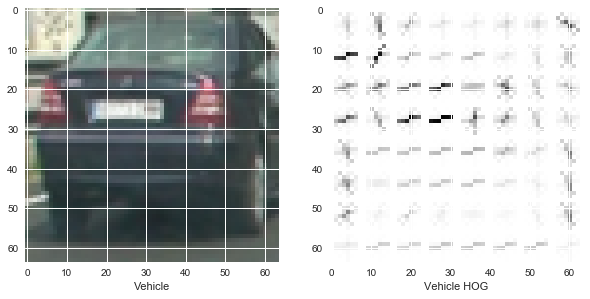

In [21]:
vehicle_data = load_data(VEHICLE_IMAGES)
v = plt.imread(vehicle_data[999])
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(v[:,:,0], ORIENT, PX_PER_CELL, CELL_PER_BLOCK,vis=True, feature_vec=True)


plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(v)
plt.xlabel('Vehicle')
#
plt.subplot(1, 2, 2)
plt.imshow(hog_image)
plt.xlabel('Vehicle HOG')
plt.show(block=True)

non-vehicles/**/*.png
non-vehicles/Extras/extra1.png
non-vehicles/Extras/extra10.png
non-vehicles/Extras/extra100.png
non-vehicles/Extras/extra1000.png
non-vehicles/Extras/extra1001.png
non-vehicles/Extras/extra1002.png
non-vehicles/Extras/extra1003.png
non-vehicles/Extras/extra1004.png
non-vehicles/Extras/extra1005.png
non-vehicles/Extras/extra1006.png
non-vehicles/Extras/extra1007.png
non-vehicles/Extras/extra1008.png
non-vehicles/Extras/extra1009.png
non-vehicles/Extras/extra101.png
non-vehicles/Extras/extra1010.png
non-vehicles/Extras/extra1011.png
non-vehicles/Extras/extra1012.png
non-vehicles/Extras/extra1013.png
non-vehicles/Extras/extra1014.png
non-vehicles/Extras/extra1015.png
non-vehicles/Extras/extra102.png
non-vehicles/Extras/extra103.png
non-vehicles/Extras/extra1032.png
non-vehicles/Extras/extra1033.png
non-vehicles/Extras/extra1034.png
non-vehicles/Extras/extra1035.png
non-vehicles/Extras/extra1036.png
non-vehicles/Extras/extra1037.png
non-vehicles/Extras/extra1038.png
n

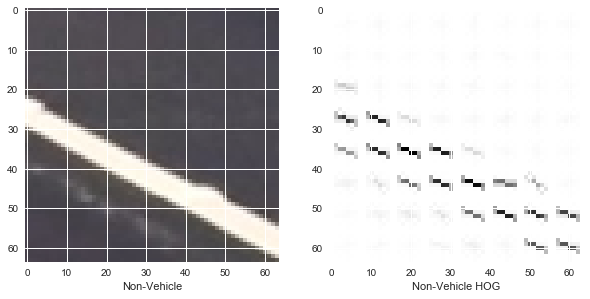

In [22]:
non_vehicle_data = load_data(NON_VEHICLE_IMAGES)
nv = plt.imread(non_vehicle_data[999])
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(nv[:,:,0], ORIENT, PX_PER_CELL, CELL_PER_BLOCK,vis=True, feature_vec=True)


plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(nv)
plt.xlabel('Non-Vehicle')
#
plt.subplot(1, 2, 2)
plt.imshow(hog_image)
plt.xlabel('Non-Vehicle HOG')
plt.show(block=True)

In [23]:
# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [24]:
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

## Train Test Split

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
rand_state = np.random.randint(0, 100)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.30, random_state=rand_state)

# Train the Support Vector Classifier

In [28]:
from sklearn.svm import LinearSVC

In [29]:
svc = LinearSVC(C=5)

In [30]:
svc.fit(X_train,y_train)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

## Predictions and Evaluations

Now let's predict using the trained model.

In [31]:
predictions = svc.predict(X_test)

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
print(confusion_matrix(y_test,predictions))

[[2609   57]
 [  70 2592]]


In [34]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

        0.0       0.97      0.98      0.98      2666
        1.0       0.98      0.97      0.98      2662

avg / total       0.98      0.98      0.98      5328



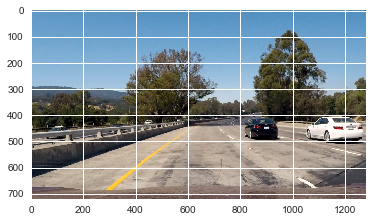

In [35]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

In [36]:
image = image.astype(np.float32)/255
draw_image = np.copy(image)

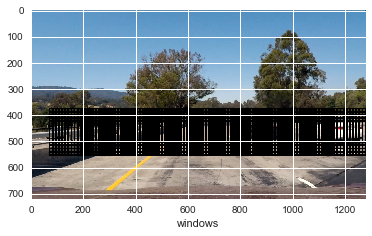

In [37]:
windows_64 = slide_window(image, x_start_stop=[None, None], y_start_stop=[375, 430],
                    xy_window=(64, 64), xy_overlap=(0.9, 0.9))

windows_128 = slide_window(image, x_start_stop=[70, None], y_start_stop=[375, 560],
                    xy_window=(128, 128), xy_overlap=(0.9, 0.9))

windows = windows_64 + windows_128

#test sliding Windows
sliding_windows = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)
plt.imshow(sliding_windows)
plt.xlabel('windows')
plt.show(block=True)

In [38]:
from collections import deque

d = deque(maxlen=10)
def pipeline(video):
    video = video.astype(np.float32) / 255

    hot_windows = search_windows(video, windows, svc, X_scaler,
                                       color_space=COLORSPACE,
                                    spatial_size=SPATIAL_SIZE,
                                    hist_bins=HIST_BINS,
                                    orient=ORIENT,
                                    pix_per_cell=PX_PER_CELL,
                                    cell_per_block=CELL_PER_BLOCK,
                                    hog_channel=HOG_CHANNEL,
                                    spatial_feat=SPATIAL_FEATURES,
                                    hist_feat=HIST_FEATURES,
                                    hog_feat=HOG_FEATURES)

    heat = np.zeros_like(video[:, :, 0]).astype(np.float)
    # Apply threshold to help remove false positives
    add_heat(heat,hot_windows)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    d.append(heatmap)
    a = np.average(d,axis=0)

    av_thresh = apply_threshold(a,2)
    labels = label(av_thresh)
    #draw hotspots on vid
    h = draw_labeled_bboxes(np.copy(video), labels)
    #scale back up
    h = h.astype(np.float32) * 255
    return h

In [39]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_path = 'project_video.mp4'
video_output = 'project_result.mp4'
output = VideoFileClip(video_path)
input = output.fl_image(pipeline)
input.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


100%|█████████▉| 1260/1261 [1:08:43<00:00,  1.01it/s]    


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_result.mp4 

